In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [3]:
## Ryan's code 
def prepare_df_rank(df, rank:str):
    '''takes in df_field containing all observations (28848), 
    and prepares a dataframe containing 16 rows (samples), and 
    col according to taxonomic rank
    '''
    df_rank = (df.groupby(['sample', rank, 'Lake', 'Edge'], as_index=False)['Abundance'].sum())
    df_rank_wide = df_rank.pivot_table(
        index=['sample', 'Lake', 'Edge'],  
        columns=rank,
        values='Abundance',
        fill_value=0  # fill missing abundance w/ 0
        ).reset_index()
    df_rank_wide.columns.name = None
    return df_rank_wide

In [4]:
## Ryan's Code
## [RUN] prepare dataframes 

df = pd.read_csv('microbe_data.csv')           # 28848 rows
df = df.iloc[:, 1:]                            # drop first col 
df = df[['taxonomy', 'sample', 'Abundance', 'Lake', 'Edge']]    # keep relevant cols

# split columns according to taxa 
tax_split = df['taxonomy'].str.split(';', expand=True)
tax_split.columns = ['Root', 'domain', 'phylum', 'class', 'order']
for col in ['domain', 'phylum', 'class', 'order']:
    tax_split[col] = tax_split[col].str.strip().str.replace(r'^[dpco]__', '', regex=True)
df = pd.concat([df, tax_split[['domain', 'phylum', 'class', 'order']]], axis=1)

df_phylum = prepare_df_rank(df, 'phylum') # 100 phylum 
df_class = prepare_df_rank(df, 'class')   # 246 phylum 
df_order = prepare_df_rank(df, 'order')   # 600 order 

Choose the number of clusters using hierarchical clustering.

In [5]:
# Dendrogram 
# remove first 3 columns 
phylum_filter = df_phylum.iloc[:,3:]
class_filter = df_class.iloc[:,3:]
order_filter = df_order.iloc[:,3:]

In [6]:
pca = PCA()
PCs = pca.fit_transform(phylum_filter)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

Text(0.5, 1.0, 'PC Space')

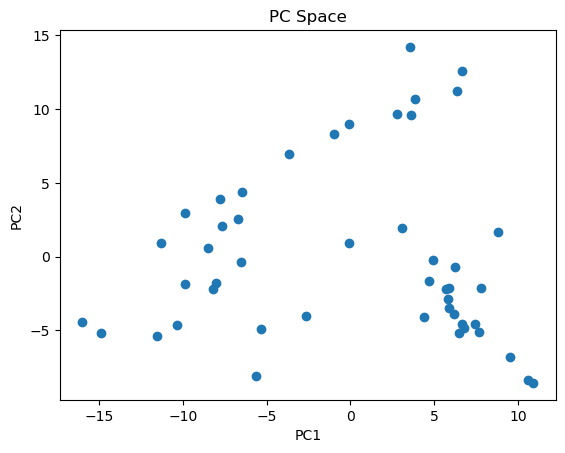

In [7]:
plt.scatter(PCs[:,0],PCs[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC Space')

In [8]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [9]:
phylum_PCs = PCs[:,:2]

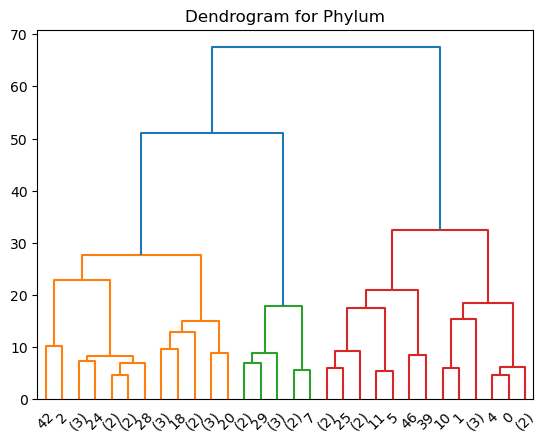

In [10]:
# hierarchical clustering for phylum 
phylum_filter = np.array(phylum_filter)
linked = linkage(phylum_filter, method = 'ward')
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp', 
          p=30)
plt.title('Dendrogram for Phylum')
plt.savefig('dendro_phylum.png')

Text(0.5, 1.0, 'Dendrogram for Class')

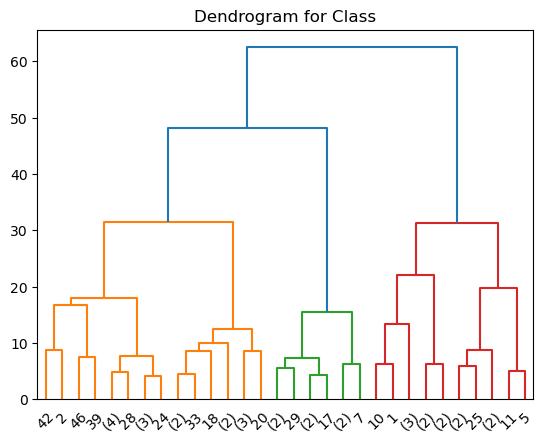

In [11]:
# hierarchical clustering for class 
class_filter = np.array(class_filter)
linked = linkage(class_filter, method = 'ward')
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp', 
          p=30)
plt.title('Dendrogram for Class')

Text(0.5, 1.0, 'Dendrogram for Order')

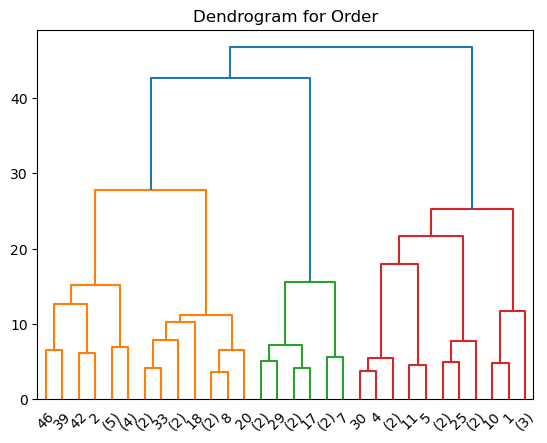

In [12]:
#hierarchical clustering for order
order_filter = np.array(order_filter)
linked = linkage(order_filter, method = 'ward')
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp', 
          p=30)
plt.title('Dendrogram for Order')

In [13]:
### now cluster
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  metric='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(phylum_filter)

### find mean pattern of each cluster
cluster_pattern = np.array([phylum_filter[cn==i].mean(axis=0) for i in range(n_clusters)])
cluster_pattern_PC = np.array([np.mean(phylum_PCs[cn==i],axis=0) for i in range(n_clusters)])

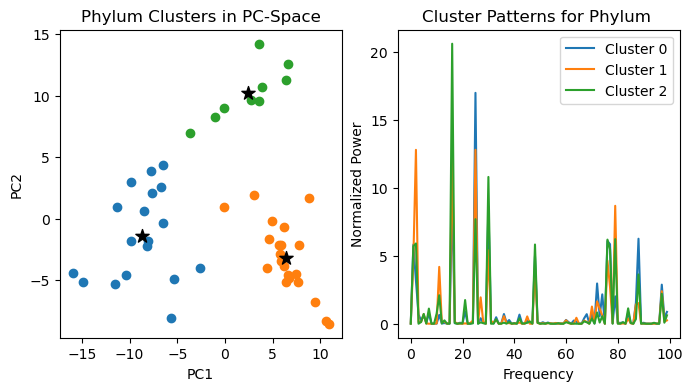

In [16]:
#visualize clusters in PC-space
plt.figure(figsize=(8,4))

plt.subplot(121)

### We could plot the following in only one line, but we want to ensure that our clusters have the same colors!
for i in range(n_clusters):
    plt.scatter(PCs[:,0][cn==i],PCs[:,1][cn==i])
plt.scatter(cluster_pattern_PC[:,0],cluster_pattern_PC[:,1],marker='*',c='k',s=100)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('Phylum Clusters in PC-Space')

plt.subplot(122)
plt.plot(cluster_pattern.T)
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
plt.title('Cluster Patterns for Phylum ')
plt.legend([f'Cluster {i}' for i in range(n_clusters)])
plt.savefig('clustering.phylum.png')

In [12]:
## SOM 
#import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from minisom import MiniSom

In [13]:
%run som_class_dup.ipynb

In [23]:
## make dataframe with vectorized categorical data 
N = len(phylum_filter) #number of observations to use as input to SOM
obs = np.array(phylum_filter)[-N:]

#define constants (we will try 1x2 SOM, 2x2 SOM, 2x3 SOM, 3x3 SOM, and 5x7 SOM)
# here is for 1x2 SOM (Nx=1, Ny=2):
Nx = 1
Ny = 3
N_nodes = Nx*Ny # number of nodes in SOM
N_obs = np.shape(obs)[0] #number of observations 
N_dims = np.shape(obs)[1] #number of dimensions per observation
learning_rate = 1e-2
N_epochs = 100
colours_list = 'default2'

#initialize
som = SOM(Nx, Ny, obs, N_epochs, linewidth = 4, colours_list = colours_list)
som.initialize_map(node_shape = 'rect')

#train
som.train_map(learning_rate)
z = som.z #this is the pattern of each BMU
z_epochs = som.z_epochs #this is the pattern of each BMU through training (each epoch)
bmus = BMUs(som) #bmu of each observation
freq = BMU_frequency(som) #frequency of each bmu
_,bmus_colours = colourmap_2D(colours_list = colours_list, Nx = Nx, Ny = Ny) #colours of each bmu, for plotting
QE = som.QE() #quantization error of map
TE = som.TE() #topographic error of map

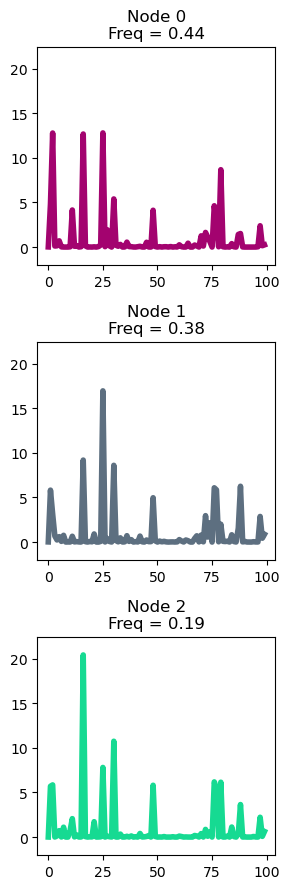

In [24]:
fig, axes = som.plot() 
plt.tight_layout()